In [2]:
import warnings
 
# 모든 경고 메시지를 무시합니다.
warnings.filterwarnings("ignore")

In [5]:
import os
import json
import requests
import time
from openai import AzureOpenAI
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

client = AzureOpenAI(
  azure_endpoint = os.getenv("EXER_AZURE_OPENAI_ENDPOINT"),
  api_key= os.getenv("EXER_AZURE_OPENAI_API_KEY"),
  api_version="2024-05-01-preview"
)


WEATHER_DATA = {
    "tokyo": None,
    "san francisco": None,
    "paris": None,
    "seoul": None
}

# Simplified timezone data
TIMEZONE_DATA = {
    "tokyo": "Asia/Tokyo",
    "san francisco": "America/Los_Angeles",
    "paris": "Europe/Paris",
    "seoul" : "Asia/Seoul"
}

def get_current_weather(location, unit=None):
    """Get the current weather for a given location"""
    location_lower = location.lower()

    # print(f"get_current_weather called with location: {location}, unit: {unit}")  
    
    for key in WEATHER_DATA:
        if key in location_lower:
            # print(f"Weather data found for {key}")  
            # weather = WEATHER_DATA[key]

            geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={key}&count=1&language=ko"
            geo = requests.get(geo_url).json()

            lat, lon = geo['results'][0]['latitude'], geo['results'][0]['longitude']

            weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,relative_humidity_2m,weather_code,rain,precipitation,wind_speed_10m,wind_direction_10m"
            data = requests.get(weather_url).json()

            return json.dumps({
                "location": location,
                "temperature": data["current"]["temperature_2m"],
                "relative_humidity": data["current"]["relative_humidity_2m"],
                "weather_code": data["current"]["weather_code"],
                "rain": data["current"]["rain"],
                "precipitation": data["current"]["precipitation"],
                "wind_speed": data["current"]["wind_speed_10m"],
                "wind_direction": data["current"]["wind_direction_10m"],
                "unit": None
            })
    
    # print(f"No weather data found for {location_lower}")  
    return json.dumps({"location": location, "temperature": "unknown"})

def get_current_time(location):
    """Get the current time for a given location"""
    print(f"get_current_time called with location: {location}")  
    location_lower = location.lower()
    
    for key, timezone in TIMEZONE_DATA.items():
        if key in location_lower:
            # print(f"Timezone found for {key}")  
            current_time = datetime.now(ZoneInfo(timezone)).strftime("%I:%M %p")
            return json.dumps({
                "location": location,
                "current_time": current_time
            })
    
    # print(f"No timezone data found for {location_lower}")  
    return json.dumps({"location": location, "current_time": "unknown"})

assistant = client.beta.assistants.create(
  model="gpt-4o-mini", # replace with model deployment name.
  instructions="당신은 날씨를 알려주는 봇입니다. 모르는 지역은 솔직히 모른다고 하세요.",
  tools = [
      {
          "type": "function",
          "function": {
              "name": "get_current_weather",
              "description": "Get the current weather in a given location",
              "parameters": {
                  "type": "object",
                  "properties": {
                      "location": {
                          "type": "string",
                          "description": "The city name, e.g. San Francisco MUST be translated into English",
                      },
                      "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                  },
                  "required": ["location"],
              },
          }
      },
      {
          "type": "function",
          "function": {
              "name": "get_current_time",
              "description": "Get the current time in a given location",
              "parameters": {
                  "type": "object",
                  "properties": {
                      "location": {
                          "type": "string",
                          "description": "The city name, e.g. San Francisco MUST be translated into English",
                      },
                  },
                  "required": ["location"],
              },
          }
      }, {"type":"code_interpreter"}
  ],
  tool_resources={},
  temperature=1,
  top_p=1
)

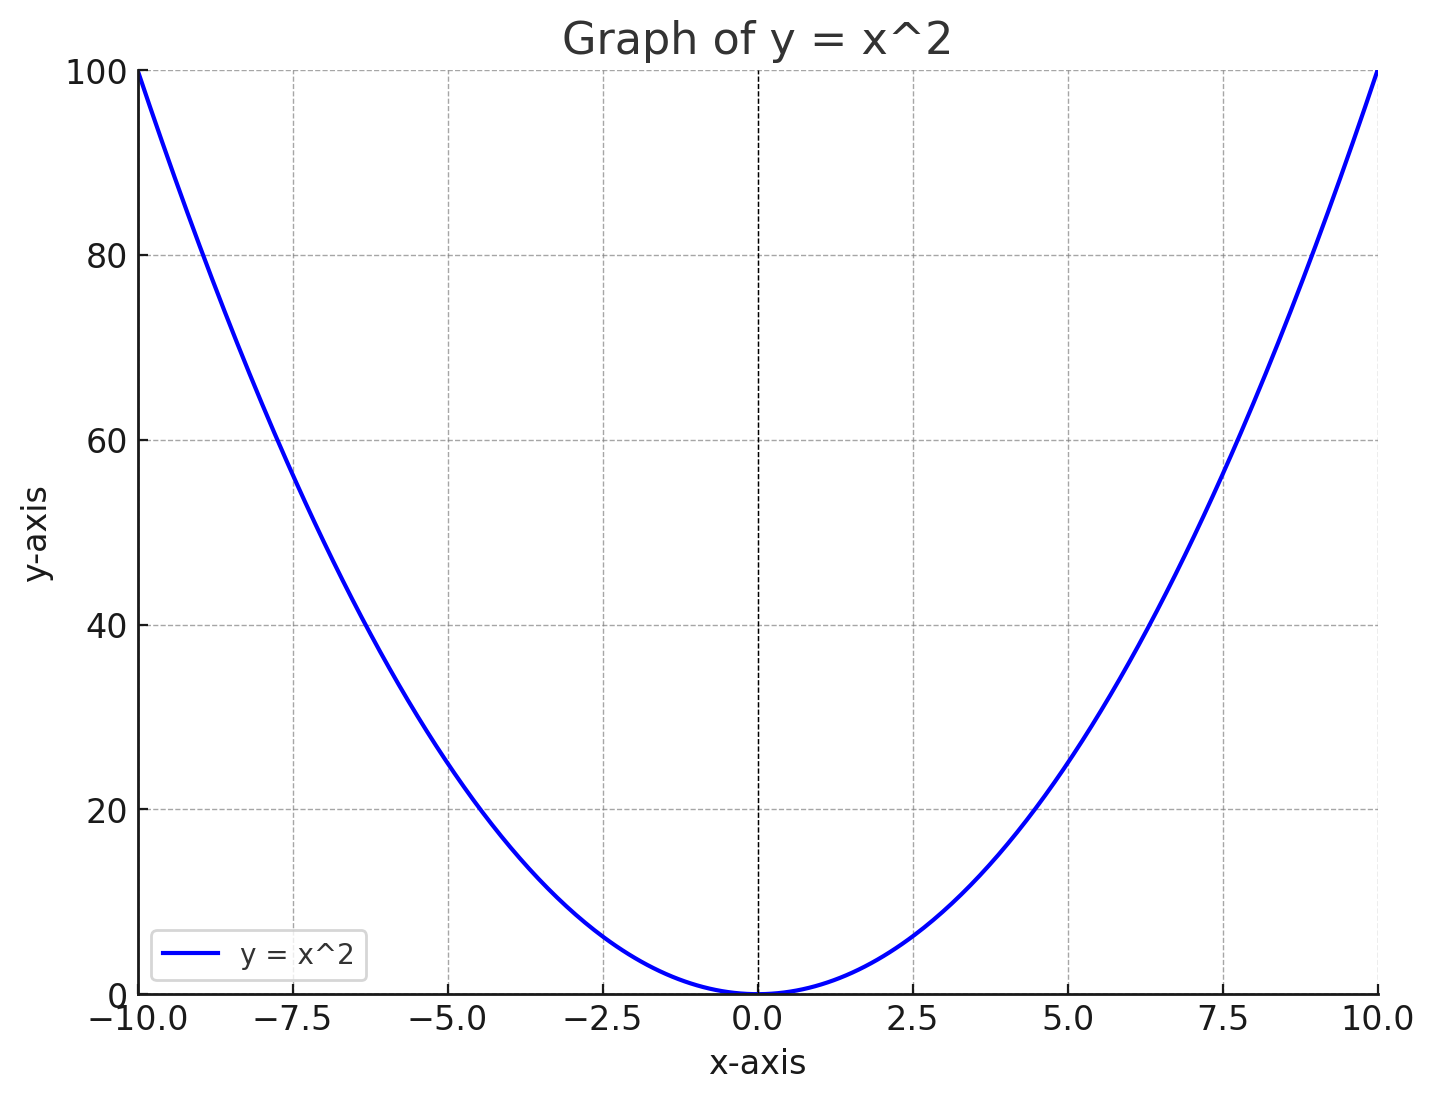

위 그래프는 \( y = x^2 \)의 형태입니다. x축을 기준으로 대칭인 포물선 형태로, 원점(0, 0)을 꼭짓점으로 가지고 있습니다. x의 값이 커질수록 y의 값도 증가합니다.


In [4]:
# Create a thread
thread = client.beta.threads.create()

# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="y=x^2의 그래프를 그려줘"
)

# Run the thread
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

# Looping until the run completes or fails
while run.status in ['queued', 'in_progress', 'cancelling']:
  
    time.sleep(1)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )

    if run.status == 'completed':
        messages = client.beta.threads.messages.list(
          thread_id=thread.id
        )

        for content in  messages.data[0].content :
            if content.type == "text" :
                print(content.text.value)

            elif content.type == "image_file" :
                image_id = content.image_file.file_id
                image_data = client.files.content(image_id).read()
                display(Image(image_data))

    elif run.status == 'requires_action':

        tool_outputs = []

        for tool_call in run.required_action.submit_tool_outputs.tool_calls :
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)
            # print(f"Function call: {function_name}")  
            # print(f"Function arguments: {function_args}")  
            
            if function_name == "get_current_weather" :
                output = get_current_weather(
                    location=function_args.get("location"),
                    unit=function_args.get("unit")
                )
                tool_outputs.append({"tool_call_id": tool_call.id, "output": output})
            elif function_name == "get_current_time":
                function_response = get_current_time(
                    location=function_args.get("location")
                )
                tool_outputs.append({"tool_call_id": tool_call.id, "output": output})
            else:
                function_response = json.dumps({"error": "Unknown function"})
                  
        run = client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )


In [ ]:
SyncCursorPage[Message](data=[Message(id='msg_go1y9ujGPIBh95BOlG5D9vam',
                                      assistant_id='asst_mEIzfT99Mx48uaXX8OEaKgur',
                                      attachments=[], completed_at=None,
                                      content=[ImageFileContentBlock(image_file=ImageFile(file_id='assistant-QehSf9F34tpQf9PpzxcU7o',
                                                                                          detail=None), type='image_file'),
                                                                                          TextContentBlock(text=Text(annotations=[], value='여기 \\(y = x^2\\)의 그래프가 있습니다. 그래프는 원점을 기준으로 아래쪽에서 위쪽으로 볼록한 형태를 보이고 있습니다. x의 값이 줄어들면 y도 줄어들고, x의 값이 클수록 y 값은 증가합니다. 추가적으로 궁금한 점이 있다면 말씀해 주세요!'), type='text')], created_at=1764315806, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_elCotlN58OpmxV6Rqc5icPrC', status=None, thread_id='thread_vyDDGnIy2Czr9560SmMqv6xP'), Message(id='msg_2GJyM287LrOwv10sjhp78mFS', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='y=x^2의 그래프를 그려줘'), type='text')], created_at=1764315795, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_vyDDGnIy2Czr9560SmMqv6xP')], has_more=False, object='list', first_id='msg_go1y9ujGPIBh95BOlG5D9vam', last_id='msg_2GJyM287LrOwv10sjhp78mFS')